# Testing Black-Scholes model with historical S&P500 data

Imports and set magics:

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this project, I will be testing the Black-Scholes model against current options prices. The Black-Scholes model was developed in 1973 and is the most widely-used model for pricing options, but since it is a very restrictive model in terms of assumptions, there is a possibility that its predictions can deviate from the actual options prices given by the market.

An option is a financial derivative, a contract which gives the buyer (when buying a call option) the right, but not the obligation to buy an underlying asset at a specific price on a given date in the future.

The Black-Scholes model is given by:
$C(S_t,t)=S_tN(d_+)-Ke^{-r\tau}N(d_-)$
$d_+=\frac{1}{\sigma\sqrt{\tau}}[ln(S_t/K)+(r+\sigma^2/2)\tau]$
$d_-=d_+-\sigma\sqrt{\tau}$

The data will consist of historical prices for the S&P 500 index as well as for the Novo Nordisk stock.

# Read and clean data

In [77]:

SP500 = pd.read_csv("dataX.csv") # I first read the data for S&P500 as a pandas dataframe
Novo = pd.read_csv('dataY.csv')
# I then fix the date, so that dates can be displayed correct
SP500['Date'] = pd.to_datetime(SP500['Date'])
SP500.set_index('Date', inplace=True)
Novo['Date'] = pd.to_datetime(Novo['Date'])
Novo.set_index('Date', inplace=True)

# Sort the DataFrame by the Date index in ascending order
SP500 = SP500.sort_index()
Novo = Novo.sort_index()

## Explore each data set

I will first show some graphs, which illustrate the historical price movements of the S&P 500 and Novo Nordisk.

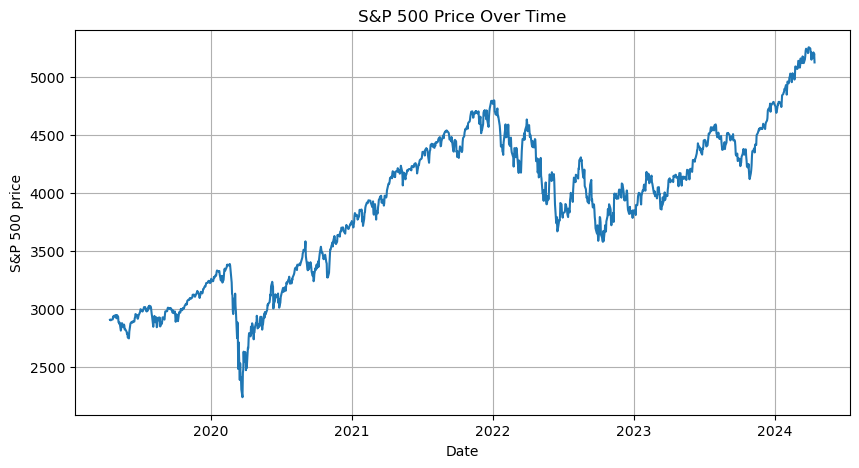

In [100]:
plt.figure(figsize=(10, 5))
plt.plot(SP500['Close'], label='Close Price')
plt.title('S&P 500 Price Over Time')
plt.xlabel('Date')  # X-axis label  # Y-axis label  # Add a legend
plt.ylabel('S&P 500 price')
plt.grid(True)  # Add gridlines
plt.show()  # Display the plot

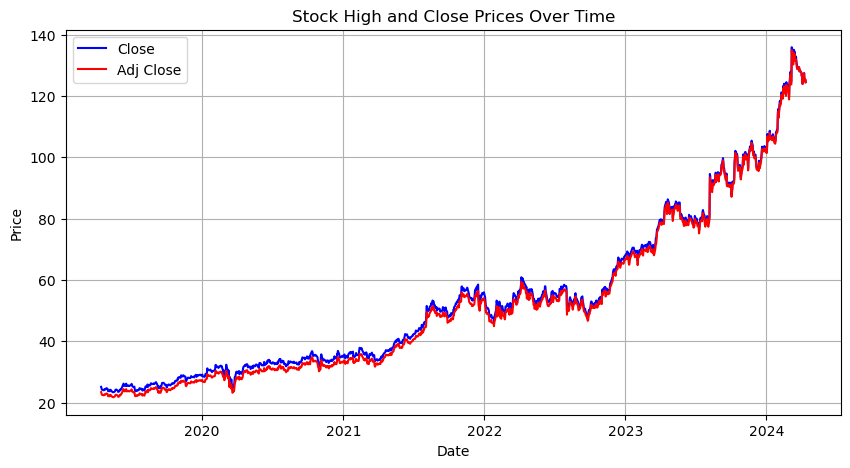

In [97]:
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(Novo.index, Novo['Close'], label='Close', color='blue')  # Plot the High price
plt.plot(Novo.index, Novo['Adj Close'], label='Adj Close', color='red')  # Plot the High price

plt.title('Stock High and Close Prices Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Price')  # Y-axis label
plt.legend()  # Add a legend to distinguish the lines
plt.grid(True)  # Add gridlines for better readability

plt.show()  # Display the plot

Here, we can see that there is a difference in the prices. The blue line shows the *close price* and the red line shows the *adjusted close price*. In this project, I will primarily use the *adjusted close price*, since this is adjusted for dividens and stock splits.

# Comparing S&P 500 and Novo Nordisk

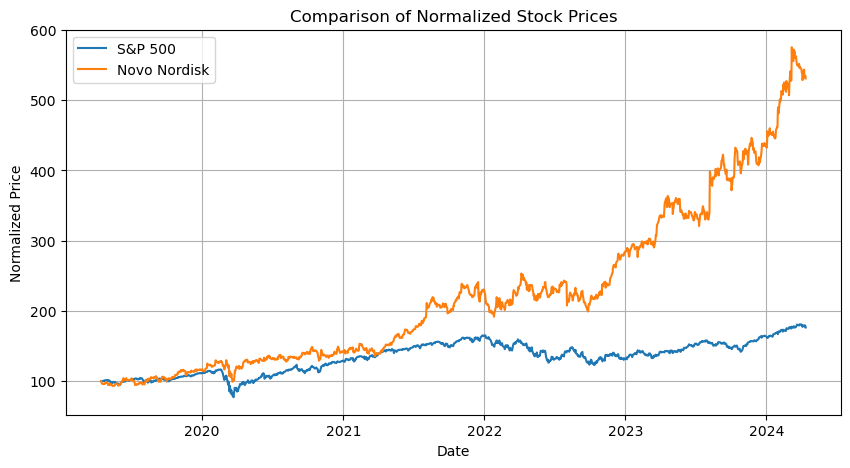

In [89]:
SP500['Normalized'] = SP500['Close'] / SP500['Close'].iloc[0] * 100 # normalizing prices
Novo['Normalized'] = Novo['Adj Close'] / Novo['Adj Close'].iloc[0] * 100

# plotting figure
plt.figure(figsize=(10, 5))
plt.plot(SP500.index, SP500['Normalized'], label='S&P 500')
plt.plot(Novo.index, Novo['Normalized'], label='Novo Nordisk')
plt.title('Comparison of Normalized Stock Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()

It is quite clear from the graph above, that Novo Nordisk has increased by a lot more than the S&P 500 in the last five years.
But actually, the return of the asset does not play a role in determining the option price, only the volatility of the asset, which we also need to calculate.

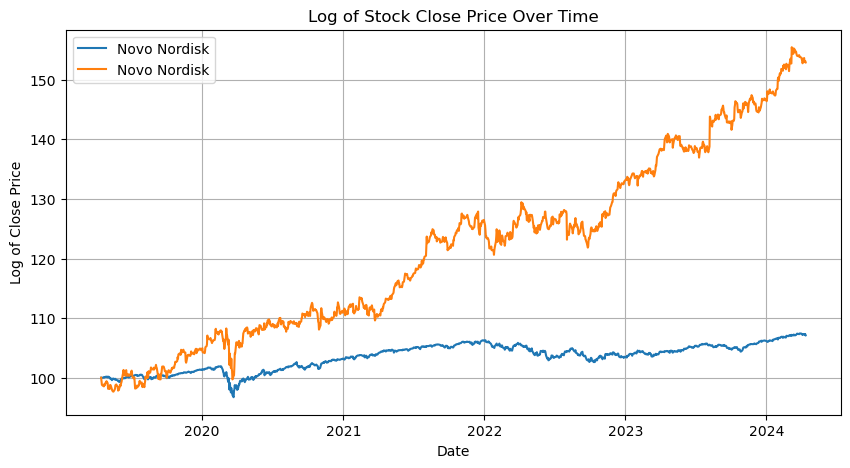

In [96]:
SP500['Log_Close'] = np.log(SP500['Close']) # finding log-prices
Novo['Log_Close'] = np.log(Novo['Adj Close'])
SP500['Log_Normalized'] = SP500['Log_Close'] / SP500['Log_Close'].iloc[0] * 100 # normalizing log-prices
Novo['Log_Normalized'] = Novo['Log_Close'] / Novo['Log_Close'].iloc[0] * 100


# Plotting the log of the Close price
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(SP500.index, SP500['Log_Normalized'], label='S&P 500')
plt.plot(Novo.index, Novo['Log_Normalized'], label='Novo Nordisk')
plt.title('Log of Stock Close Price Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Log of Close Price')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Add gridlines
plt.show()  # Display the plot

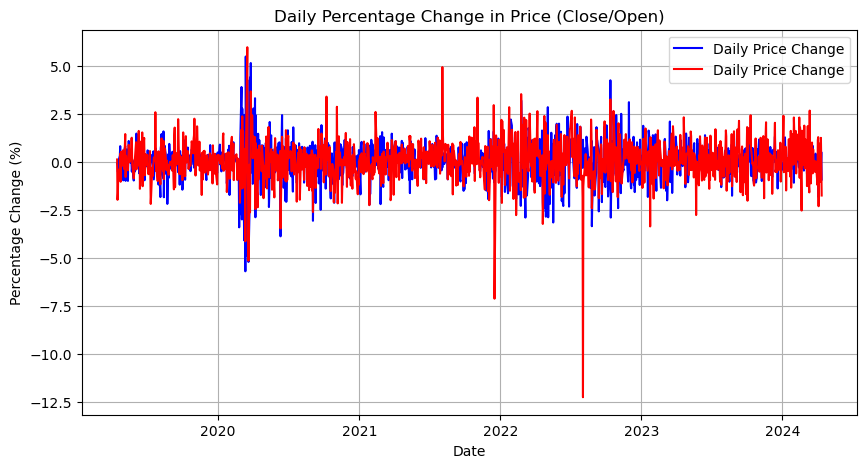

In [98]:
SP500['Daily Change (%)'] = ((SP500['Close'] / SP500['Open'] - 1) * 100) # calculating daily changes
Novo['Daily Change (%)'] = ((Novo['Close'] / Novo['Open'] - 1) * 100)

# Plotting the daily changes
plt.figure(figsize=(10, 5))
plt.plot(SP500.index, SP500['Daily Change (%)'], label='Daily Price Change', color='blue')
plt.plot(Novo.index, Novo['Daily Change (%)'], label='Daily Price Change', color='red')
plt.title('Daily Percentage Change in Price (Close/Open)')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(True)
plt.show()

*Note: I have used the close price, and not adjusted close price here, since using the adjusted price throws off the calculations.*
Here, we see the daily percentage change of each asset, and it seems that Novo Nordisk has larger swings, both to the upside and the downside.


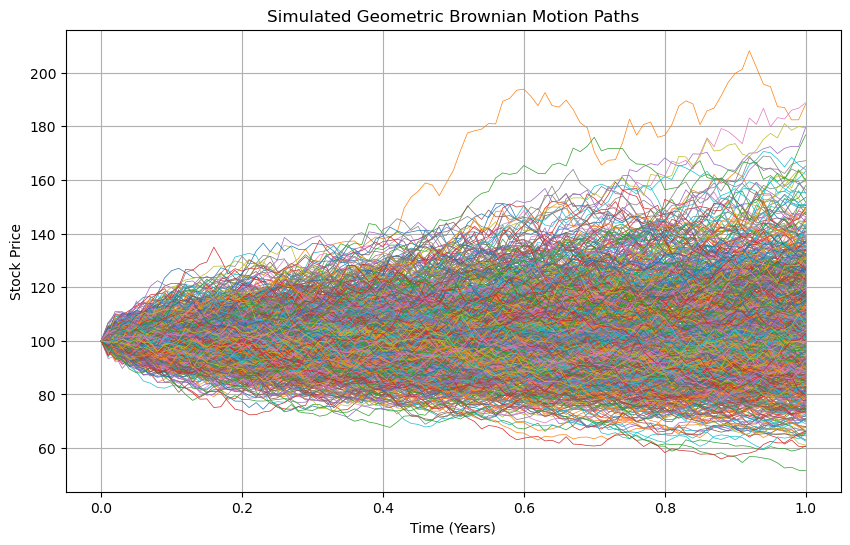

interactive(children=(FloatSlider(value=100.0, description='Initial Stock Price:', max=150.0, min=50.0, step=1…

<function __main__.simulate_gbm(S0, mu, sigma, T=1.0, dt=0.01, simulations=10)>

In [136]:
from ipywidgets import interact, FloatSlider
import matplotlib.ticker as ticker
# Parameters
S0 = 100         # Initial stock price
mu = 0.05        # Expected return (drift coefficient)
sigma = 0.2      # Volatility (standard deviation of returns)
T = 1.0          # Time horizon in years
dt = 0.01        # Time step
N = int(T / dt)  # Number of time steps
simulations = 1000  # Number of simulation paths

# Preallocate an array to store the simulations
S = np.zeros((N + 1, simulations))
S[0] = S0

# Generate the paths
for t in range(1, N + 1):
    Z = np.random.standard_normal(simulations)  # Random normal values for this step
    S[t] = S[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Plotting
plt.figure(figsize=(10, 6))
for i in range(simulations):
    plt.plot(np.arange(N + 1) * dt, S[:, i], lw=0.5)
plt.title('Simulated Geometric Brownian Motion Paths')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

from ipywidgets import interact, FloatSlider, IntSlider

# create interactive widgets
interact(simulate_gbm,
         S0=FloatSlider(value=100, min=50, max=150, step=1, description='Initial Stock Price:'),
         mu=FloatSlider(value=0.05, min=-0.1, max=0.2, step=0.01, description='Expected Return (mu):'),
         sigma=FloatSlider(value=0.2, min=0.01, max=0.5, step=0.01, description='Volatility (sigma):'),
         T=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Time Horizon (Years):'),
         dt=FloatSlider(value=0.01, min=0.005, max=0.1, step=0.005, description='Time Step:'),
         simulations=IntSlider(value=10, min=1, max=1000, step=1, description='Number of Simulations:'))



Sine it is an underlying assumption that the stock price follows a Geometric Brownian Motion, I figured that it would be nice to see some simulations of how a stock price could be expected to move.
I have also created a slider, which makes it possible to change given values in the formula.

# Analysis

In order to calculate the theoretical options price, I first have to calculate the volatility of the two underlying assets.

<Figure size 1000x500 with 0 Axes>

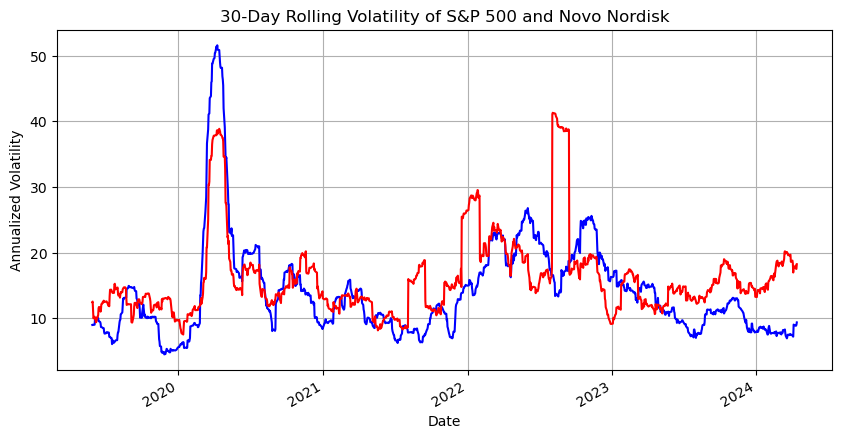

In [112]:
# Calculate daily standard deviation of returns
SP500_daily_std = SP500['Daily Change (%)'].std()
Novo_daily_std = Novo['Daily Change (%)'].std()

# Annualize the standard deviation
SP500_annualized_volatility = SP500_daily_std * np.sqrt(252)
Novo_annualized_volatility = Novo_daily_std * np.sqrt(252)

SP500['Rolling Volatility'] = SP500['Daily Change (%)'].rolling(window=30).std() * np.sqrt(252)
plt.figure(figsize=(10, 5))
Novo['Rolling Volatility'] = Novo['Daily Change (%)'].rolling(window=30).std() * np.sqrt(252)
plt.figure(figsize=(10, 5))
SP500['Rolling Volatility'].plot(title='30-Day Rolling Volatility of S&P 500 and Novo Nordisk', color='blue', label='S&P 500')
Novo['Rolling Volatility'].plot(color='red', label='Novo Nordisk')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.show()

Here, we see the historical volatility of both assets, and it can be seen that Novo Nordisk (red), genereally has been more volatile than the S&P 500.

There is however, another way to find out the volatility of the S&P 500, and that is by using the VIX (CBOE Volatility Index).


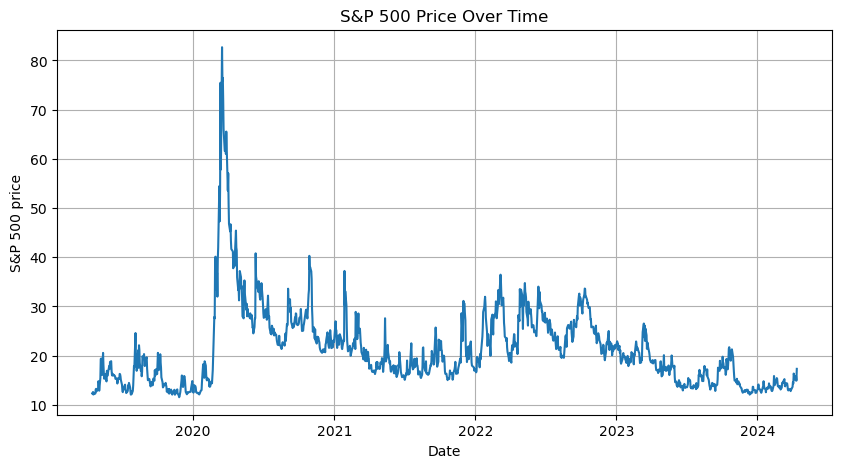

In [121]:
Vix = pd.read_csv("Vix.csv") # I first read the data for S&P500 as a pandas dataframe
# I then fix the date, so that dates can be displayed correct
Vix['Date'] = pd.to_datetime(Vix['Date'])
Vix.set_index('Date', inplace=True)

# Sort the DataFrame by the Date index in ascending order
Vix = Vix.sort_index()

Vix.replace('null', pd.NA, inplace=True)

# Remove rows where all data columns are NaN, ignoring the Date column
Vix.dropna(how='all', subset=[col for col in Vix.columns if col != 'Date'], inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(Vix['Close'], label='Close Price')
plt.title('S&P 500 Price Over Time')
plt.xlabel('Date')  # X-axis label  # Y-axis label
plt.ylabel('S&P 500 price')
plt.grid(True)  # Add gridlines
plt.show()  # Display the plot

As it can be seen by comparing the two figures, the two graphs are similar but not identical. 
To calculate the S&P 500 options price, I will be using the VIX, since it is a more widely used estimate of the volatility, comparing to calculating it on your own.

In [202]:
SP500_price = SP500['Close'].iloc[-1]
SP500_strike_price = SP500_price*1.02
time_to_expiration = 1/12  # 1 year
risk_free_rate = 0.045  # 4.5%, 10 year US treasury bond yield
SP500_volatility = Vix['Close'].iloc[-1]*0.01  # Volatility, using the VIX

# Calculate call and put option prices
call_price = black_scholes(SP500_price, SP500_strike_price, time_to_expiration, risk_free_rate, SP500_volatility, "call")
put_price = black_scholes(SP500_price, SP500_strike_price, time_to_expiration, risk_free_rate, SP500_volatility, "put")

print(f"S&P 500 Call Option Price: ${call_price:.2f}")
print(f"S&P 500 Put Option Price: ${put_price:.2f}")


S&P 500 Call Option Price: $66.76
S&P 500 Put Option Price: $149.67


In [207]:
Novo_stock_price = Novo['Adj Close'].iloc[-1]
Novo_strike_price = current_stock_price*1.004
time_to_expiration = 1/12  # 1 year
risk_free_rate = 0.045  # 5%
Novo_volatility = Novo_daily_std * np.sqrt(252) * 0.01


# Calculate call and put option prices
call_price = black_scholes(Novo_stock_price, Novo_strike_price, time_to_expiration, risk_free_rate, Novo_volatility, "call")
put_price = black_scholes(Novo_stock_price, Novo_strike_price, time_to_expiration, risk_free_rate, Novo_volatility, "put")

print(f"Novo Call Option Price: ${call_price:.2f}")
print(f"Novo Put Option Price: ${put_price:.2f}")

Novo Call Option Price: $2.47
Novo Put Option Price: $2.50


Now that we have our theoretical options prices, we can compare them to actual options prices.
I have gathered prices for two options, a call and a put for each asset. All options expire May 15th 2024.
The prices have been collected from Yahoo Finance on May 14th.

S&P 500 Call Option price: 51.80 (implied volatility is 15.13%)
S&P 500 Put Option price: 132.91 (implied volatility is 11.46%)

Novo Nordisk Call Option price: 5.48 (implied volatility is 38.15%)
Novo Nordisk Put Option price: 5.30 (implied volatility is 33.61%)

As we can see, the S&P 500 options are actually overpriced, according to the Black-Scholes model, while the Novo Nordisk options are very underpriced.

This is due to the implied volatility. Since the implied volatility of Novo Nordisk is much higher than the historical volatility, the options will necessarily be more valuable, and vice verse for the S&P 500 options.

When running the tests with the implied volatility for Novo Nordisk i got a call price of 5.00 and a put price of 5.03, which is much closer to the actual options prices.

# Conclusion

In this project I have looked at two assets, the S&P 500 and Novo Nordisk. 
I have found out that historically, Novo Nordisk has been more volatile than the S&P 500.

When calculating theoretical option prices and comparing them to actual option, we have seen that the volatility plays a big role in determining the options prices, and calculating the options prices with historical volatility, may not prove to be the most accurate predictor of actual options prices.

In conclusion, the Black-Scholes model of options prices may be a simple and widely used model, but it is not necessarily the most accurate model for options prices.

Further studies could include looking at more sophisticated models, such as the Heston stochastic volatility model or using a GARCH model. While these are more computationally intensive, they may provide a price that aligns more with the actual prices observed in the market.

